# 第一回深層生成モデルの基礎を演習を交えて復習

In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib
import random
import copy
from keras.datasets import mnist
import seaborn as sns
import math
from scipy import stats
from IPython.display import display, Markdown

### 例１：）(28, 28)の画像を平坦にした786次元のデータがある。各次元は独立しており、$(x \in{0, 1})$のどちらかの値を取る。この画像を確率分とみなした時、この確率分布を近似する生成モデル$Pμ(x)$を近似せよ

### モデルの近似

真の分布(経験分布)$\hat{P}^N_{data}(x)$に生成モデル$P_μ(x)$を近似する。つまり、真の分布と生成モデルのKLダイバージェンスを最小化する。これは、xが生成モデルの分布から生成される確率が最も尤もらしくなるパラメータμを求めること。すなわち、生成モデルのパラメータμを最尤推定することに等しい

なお、今回は各次元が$(x \in 0, 1)$の値を取り、独立しているため真の分布(経験分布)はベルヌーイ分布の集合に従うと仮定する。


ベルヌーイ分布の確率質量関数
$$
P_{\mu}({\bf x})= \mu^x(1 - \mu)^{1 - x}
$$

**つまり、各次元それぞれに個別のパラメータを持ったベルヌーイ分布が存在すると考えるので，一つの次元についてのみ記述すると以下のように表される(つまり$D=784$のインデックスを表す$d$を省略)．**

尤度関数
$$
P_{\mu}({\bf x})=\prod_{i=1}^{N} \mu^{x_{i}}(1-\mu)^{1-x_{i}}
$$

しかし、積の形では扱いづらいので、対数を取って和の形に変形する
$$
P_{\mu}({\bf x}) = \sum_{i=1}^{N} \log μ^{x_{i}}(1 - \mu)^{1 - x_{i}} \\
= P_{\mu}{(\bf x)} = \sum_{i=1}^{N} [x_{i}\log_\mu + 1 - x_{i} \log_\mu]
$$

これを最尤推定(パラメータμで偏微分)する
$$
0 = \sum_{i=1}^{N} [x_{i}\log_\mu + 1 - x_{i} \log_(1 - \mu)] \\
$$

第一項を偏微分
$$
\frac{\partial}{\partial \mu} = x_{i}\log_\mu \\
= x_{i} \frac{1}{\mu}
$$

第二項を偏微分
$$
\frac{\partial}{\partial \mu} = 1 - x_{i} \log_(1 - \mu)　\\
= 1 - x_{i} \frac{-1}{1 - \mu} \\
= - \frac{1- x_{i}}{1 - \mu}
$$

偏微分した第一項と第二項を再び結合し計算
$$
0 = \sum_{i=1}^N [\frac{x_{i}}{\mu} - \frac{1- x_{i}}{1 - \mu}]
$$

$$
\sum_{i=1}^{N} \frac{1- x_{i}}{1 - \mu} = \sum_{i=1}^{N} \frac{x_{i}}{\mu}
$$

成功回数をS, 失敗回数をN - Sとして定義
$$
S = \sum_{i=1}^{N} x_{i} \\
N - S = \sum_{i=1}^{N} (1 - x_{i})
$$


$$
\frac{N - S}{1 - \mu} =  \frac{S}{\mu} \\ \\
$$

$$
\mu(N - S) = S(1 - \mu) \\
$$

$$
N \mu - S \mu = S - S \mu \\
$$
$$
N \mu = S \\
$$
$$
\mu = \frac{S}{N} \\
$$

$$
\mu = \sum_{i=1}^{N} \frac{x_{i}}{N}
$$

以上のように最尤推定(KLダイバージェンスを最小化)すると、各次元のパラメータはその次元の合計値の平均となる。つまり、各次元について平均をとってあげると、真の分布(経験分布)を近似できることとなる



In [111]:
# 指定したラベルに該当するインデックスのリストを取得
def get_label_index(labels: list, t_mnist: np.ndarray) -> np.ndarray:
    label_bool = np.any([label == t_mnist for label in labels], axis=0)
    label_idxs = np.where(label_bool)[0]
    return label_idxs

# 二値化
def transfroms(data_all: np.ndarray, flatten=True, binarize=True)-> np.ndarray:
    data_all = data_all / 255.0
    
    if flatten:
        data_all = data_all.reshape(data_all.shape[0], -1)
    if binarize:
        data_all = (data_all > 0.5).astype(np.uint8)
    
    return data_all


In [112]:
# get_label_indexの役割確認コード
t_mnist = np.array([0, 1, 2, 3, 4, 1, 2, 0, 3, 4])  # MNISTのラベルの例
labels = [0, 2]  # 取得したいラベル

label_bool = np.array([t_mnist==label for label in labels])
label_bool2 = np.any([t_mnist==label for label in labels], axis=0)

print(label_bool)
print(label_bool2)


[[ True False False False False False False  True False False]
 [False False  True False False False  True False False False]]
[ True False  True False False False  True  True False False]


In [113]:
# mnistを読み込み https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

# 扱うデータのサンプルサイズ
NUM_SAMPLES = 600

# ここでは、学習データのみ取得する(60000個のデータ)
(x_mnist, t_mnist), _ = mnist.load_data()

labels = [1] # 取得するデータをラベルで指定

label_idxs = get_label_index(labels, t_mnist)

print(f"データの数 説明変数 = {x_mnist.shape}, 目的変数 = {len(t_mnist)}")

data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f"data_all: {data_all.shape}")

データの数 説明変数 = (60000, 28, 28), 目的変数 = 60000
data_all: (600, 28, 28)


<Axes: >

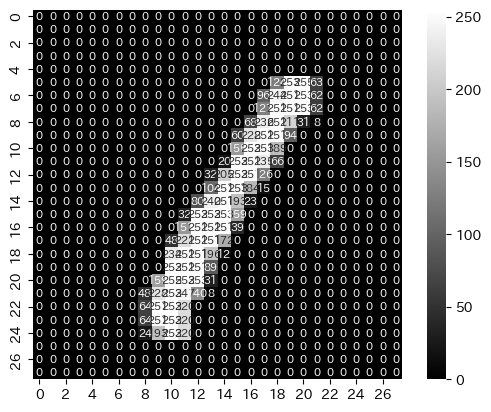

In [114]:
# 1枚分の画像をヒートマップで表示 https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.Figure(figsize=(10, 10))
sns.heatmap(data_all[0], cmap="gray", annot=True, fmt='d', annot_kws={"fontsize":8}, square=True)

In [115]:
# 各画像を一次元の平坦にし、二値化
binary_data = transfroms(data_all)
print(f"binary_data: {binary_data}, set {np.unique(binary_data)}")
binary_data.shape

binary_data: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], set [0 1]


(600, 784)

<Axes: >

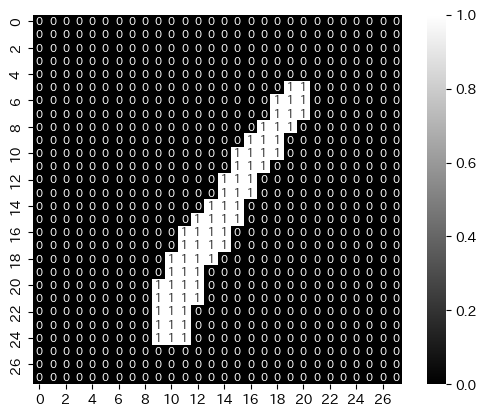

In [116]:
# 二値化した画像を確認
sns.heatmap(binary_data[0].reshape(28, 28), cmap="gray", annot=True, annot_kws={"fontsize":8}, fmt="d", square=True)

Text(0.5, 1.0, '600枚の157次元目に注目した時の分布')

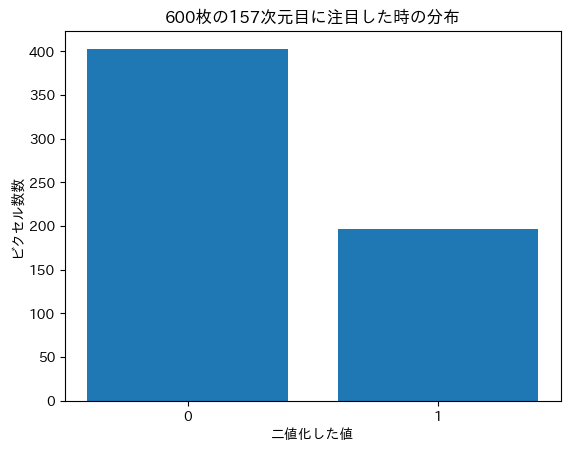

In [121]:
# 各画像のある次元の分布をプロット

TARGET_PIXEL = 157
binary_pixels = binary_data[:, TARGET_PIXEL].astype(np.int64) # (600, )

# x軸上の数値
left = [0, 1]
# 棒の高さ：[ピクセル数値が0である数, ピクセル数値が1である数]
height = [ len(binary_pixels) - sum(binary_pixels), sum(binary_pixels)]

plt.bar(left, height, align="center")
plt.xticks([0, 1]) # x軸上の数値を[1, 0]のみに指定
plt.xlabel("二値化した値")
plt.ylabel("ビクセル数数")
plt.title(f"{NUM_SAMPLES}枚の{TARGET_PIXEL}次元目に注目した時の分布")

(784,)

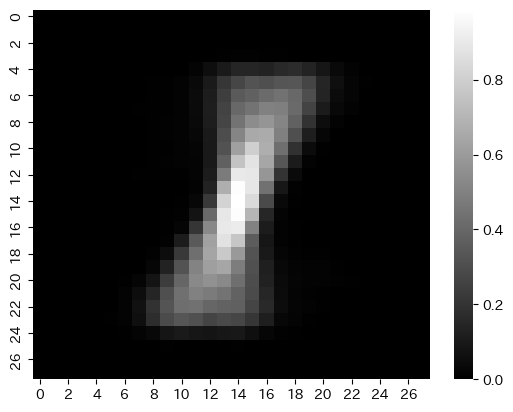

In [ ]:
# 最尤推定して求めたパラメータμを計算(ここではmu_hatとする)

mu_hat = np.mean(binary_data, axis=0)
sns.heatmap(mu_hat.reshape(28, 28), cmap="gray")
mu_hat.shape


最尤推定で求めたパラメータを使ってデータを生成してみる

なお、以下の点に注意する
- ベルヌーイ分布は、Pの確率で成功。1 - Pの確率で失敗することを示す。
- 画像は白を1, 黒を0として表す。
- そして、mnistは数字を白、背景を黒とする
- つまり、成功を白、失敗を黒とする。

**確率 μ で 1 (白) になり、それ以外は 0 (黒) になるから、乱数がμ未満の時は、白を出力するようにし、それ以外(1 - μ)の時は黒が出るようにする**

In [ ]:
# μより大きい乱数であれば1、そうでないなら０を返す要素をn個生成し、numpy配列として返す
def binomial(n, μ):
    return np.array([1 if random.uniform(0.0, 1.0) < μ else 0 for _ in range(n)])

In [179]:
# 画像を生成する関数
def generate_image(mu_hat, ax):
    generated_image = np.zeros_like(mu_hat)

    for i, mu_hat_i in enumerate(mu_hat):
        # 新しい画像を生成 (ベルヌーイ分布からサンプリング)
        generated_image[i] = binomial(1, mu_hat_i)
    if ax:
        sns.heatmap(generated_image.reshape(28, 28), cmap="gray", ax=ax)
    else:
        # 画像を表示
        sns.heatmap(generated_image.reshape(28, 28), cmap="gray")

In [ ]:
for _ in range(10):
    generate_image(mu_hat)

## 全てのラベルを近似するモデルをラベル数分生成する

In [133]:
# 各ラベルのパラメータmu_hatを返す関数
def generate_parameter(label: int, NUM_SAMPLES: int, x_mnist: np.ndarray, t_mnist : np.ndarray) -> np.ndarray:
    label_idxs = get_label_index(labels=[label], t_mnist=t_mnist)
    data_all = x_mnist[label_idxs][:NUM_SAMPLES]
    binary_data = transfroms(data_all)

    mu_hat = np.mean(binary_data, axis=0)
    return mu_hat

In [ ]:
NUM_SAMPLES = 600
(x_mnist, t_mnist), _ = mnist.load_data()
# mnistに存在するラベルの種類
labels = np.unique(t_mnist)
# パラメータのサイズ
parameter_size = x_mnist[0].flatten().shape[0]
columns = [f"P_μ{i}(x)" for i in labels]

df_data_initial = np.zeros((parameter_size, len(columns)))
# データフレームの初期化
df = pd.DataFrame(df_data_initial, columns=columns)

# データフレームにパラメータを代入
for label in labels:
    df[f"P_μ{label}(x)"] = generate_parameter(label, NUM_SAMPLES, x_mnist, t_mnist)

print(f"各列の合計を表示 \n{df.sum()}")


各列の合計を表示 
P_θ0(x)    140.133333
P_θ1(x)     61.271667
P_θ2(x)    119.093333
P_θ3(x)    114.621667
P_θ4(x)     95.930000
P_θ5(x)    100.418333
P_θ6(x)    107.996667
P_θ7(x)     92.223333
P_θ8(x)    121.703333
P_θ9(x)     97.990000
dtype: float64


### プロット

/tmp/ipykernel_9293/797953108.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  generated_image[i] = binomial(1, mu_hat_i)
/tmp/ipykernel_9293/797953108.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  generated_image[i] = binomial(1, mu_hat_i)
/tmp/ipykernel_9293/797953108.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  generated_image[i] = binomial(1, mu_hat_i)
/tmp/ipykernel_9293/797953108.py:7: DeprecationWarning: Conversion of an array with ndim > 0 t

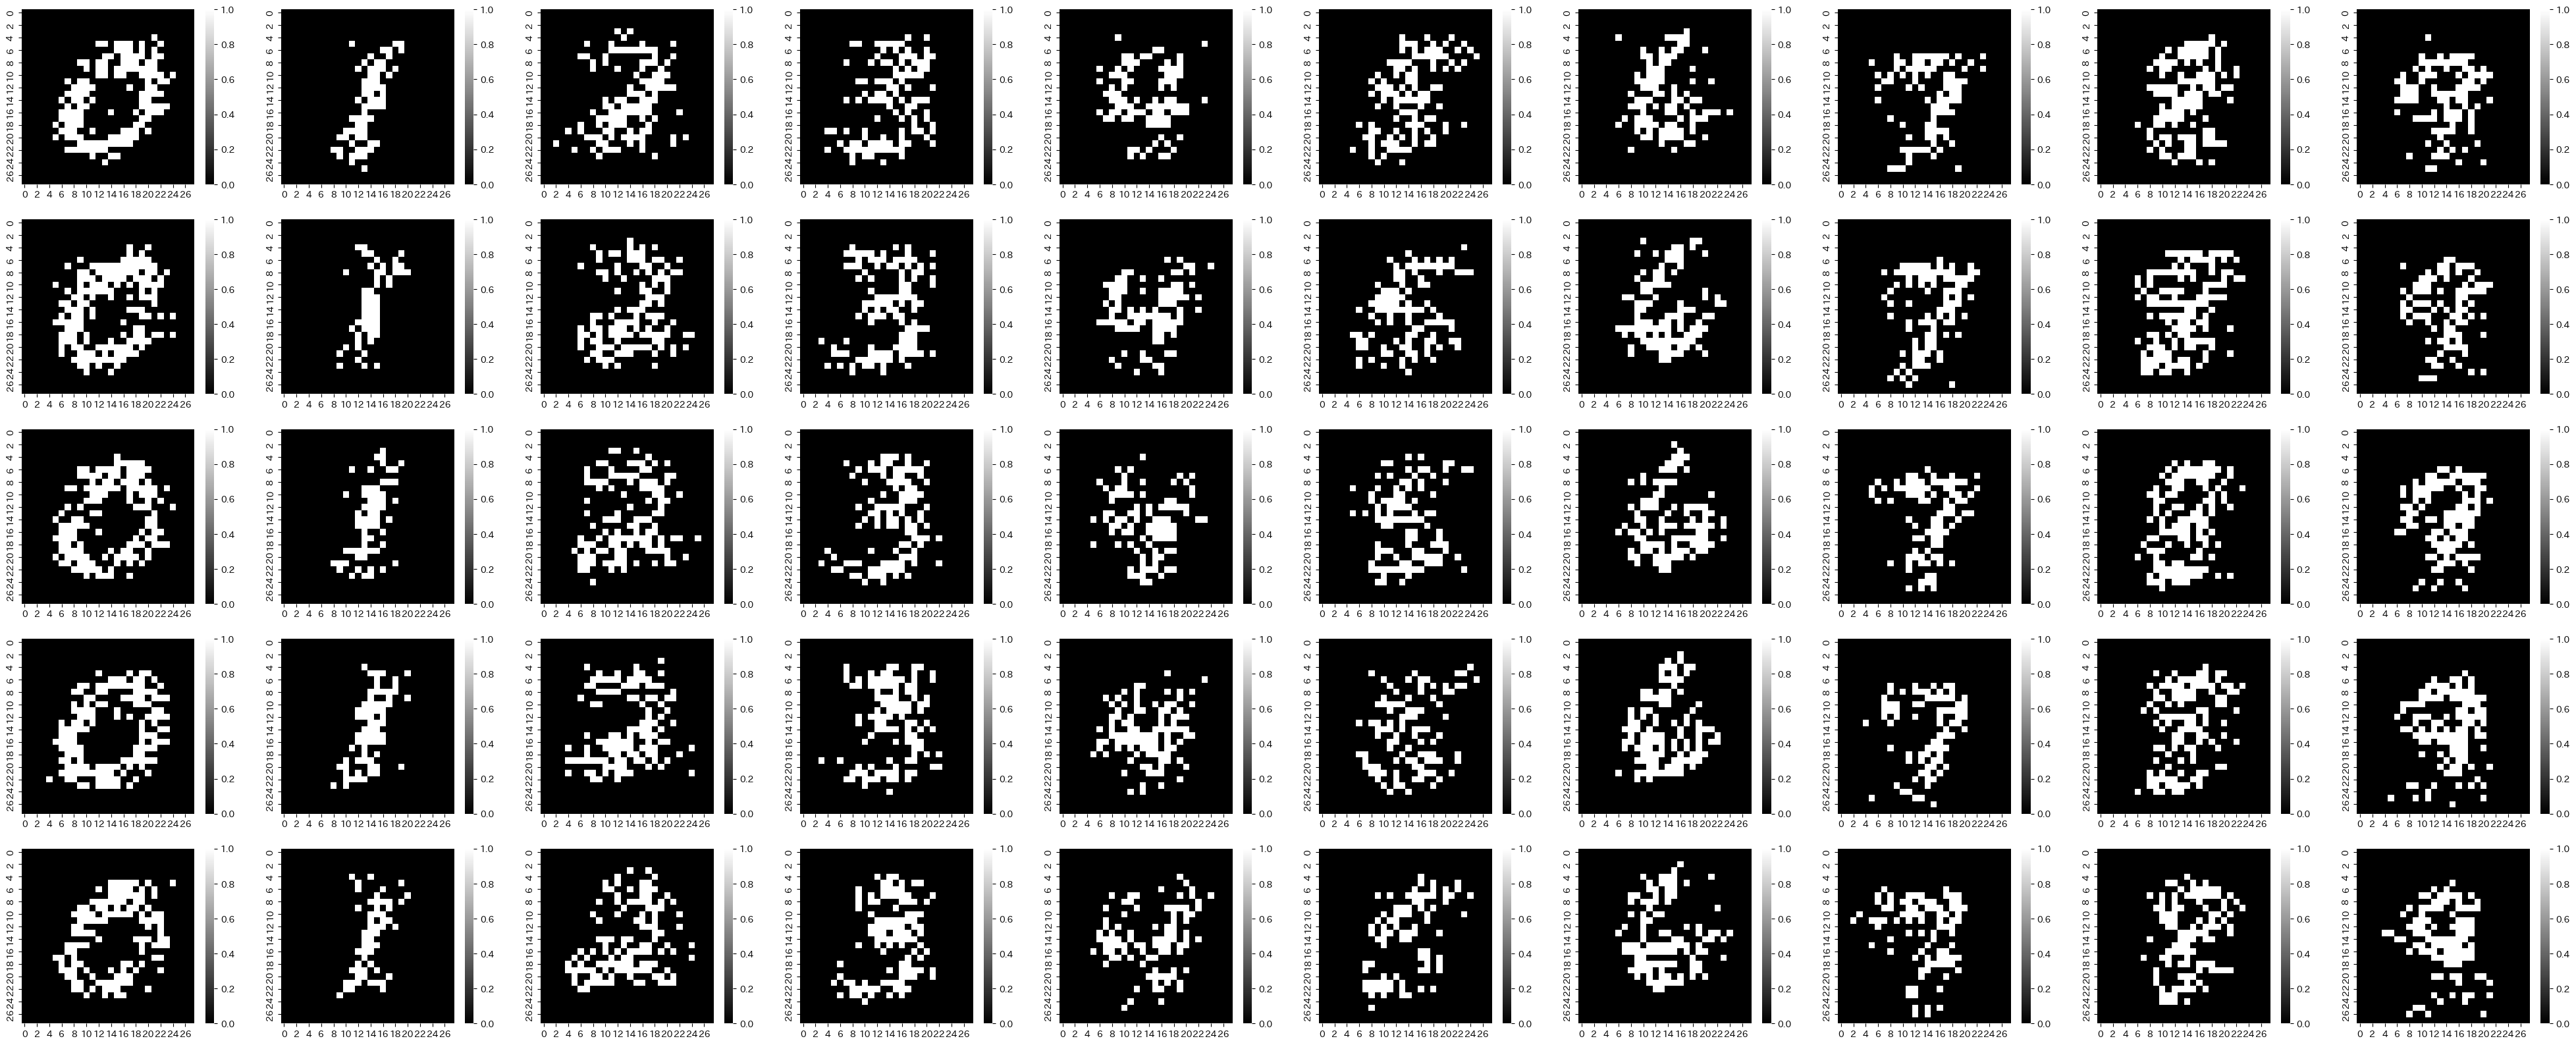

In [ ]:
fig = plt.figure(figsize=(50, 20))
plot_num =  5# 画像の生成回数
ax_i = 1

for i in range(1, plot_num + 1):
    for label in labels:
        ax = fig.add_subplot(plot_num, len(labels), ax_i)
        mu_hat = df[f"P_μ{label}(x)"].to_numpy()
        generate_image(mu_hat, ax)
        ax_i += 1
